# Domain Error Data Analysis
In this notebook, I will find out the best python modules to read in Domain data and carry out an exploratory analysis to understand problem.

## Shapefiles
The shape files can be read in via shapefile (installed as pyshp)

In [2]:
import shapefile

In [3]:
sf = shapefile.Reader('./data/Ambiental_DataJavelin_FloodMap_QA/Domain_Errors/Domains/NOR_9_1_Domain.shp')


In [4]:
sf.shapes()[0].points[0]

(412706.3804254929, 621365.3729263357)

In [5]:
sf.

SyntaxError: invalid syntax (<ipython-input-5-ecf8a6aa55d7>, line 1)

In [6]:
import matplotlib
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [7]:
patches=[Polygon(sf.shapes()[0].points, True)]


(620500.0, 622500.0000000019)

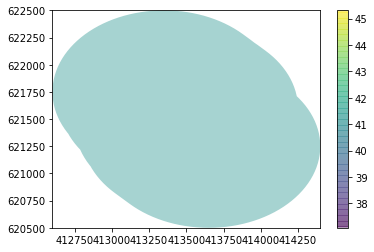

In [8]:
fig, ax = plt.subplots()

colors = 100*np.random.rand(len(patches))
p = PatchCollection(patches, alpha=0.4)
p.set_array(np.array(colors))
ax.add_collection(p)
fig.colorbar(p, ax=ax)
lims=sf.shapes()[0].bbox
plt.xlim(lims[0],lims[2])
plt.ylim(lims[1],lims[3])

## Flood sims
The Flood sims are tif files and can be read in via gdal

In [9]:
import gdal

In [10]:
floodmap=gdal.Open('./data/Ambiental_DataJavelin_FloodMap_QA/Domain_Errors/CombinedOutput_FloodMap/NOR_Fluvial_100yr.tif')

In [11]:
arr = floodmap.ReadAsArray()

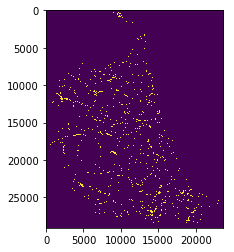

In [12]:
plt.imshow(arr)

## Plotting the two
Requires consistant frame. Geospatial information should be in tif file. Nice example @ [http://alimanfoo.github.io/2016/10/04/plotting-african-ecosystems.html](http://alimanfoo.github.io/2016/10/04/plotting-african-ecosystems.html)

In [13]:
proj_wkt = floodmap.GetProjection()
print(proj_wkt)


PROJCS["British_National_Grid",GEOGCS["GCS_OSGB_1936",DATUM["OSGB_1936",SPHEROID["Airy_1830",6377563.396,299.3249646,AUTHORITY["EPSG","7001"]],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.9996012717],PARAMETER["false_easting",400000],PARAMETER["false_northing",-100000],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]


In [14]:
from osgeo import osr

In [15]:
proj = osr.SpatialReference()
proj.ImportFromWkt(proj_wkt)
print(proj)


PROJCS["British_National_Grid",
    GEOGCS["GCS_OSGB_1936",
        DATUM["OSGB_1936",
            SPHEROID["Airy_1830",6377563.396,299.3249646,
                AUTHORITY["EPSG","7001"]],
            AUTHORITY["EPSG","6277"]],
        PRIMEM["Greenwich",0],
        UNIT["degree",0.0174532925199433]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",49],
    PARAMETER["central_meridian",-2],
    PARAMETER["scale_factor",0.9996012717],
    PARAMETER["false_easting",400000],
    PARAMETER["false_northing",-100000],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]]]


In [16]:
geo_transform = floodmap.GetGeoTransform()

In [17]:
geo_transform

(356390.0001220703, 5.0, 0.0, 647200.0001220703, 0.0, -5.0)

In [18]:
origin_x = geo_transform[0]
origin_y = geo_transform[3]
pixel_width = geo_transform[1]
pixel_height = geo_transform[5]
n_cols = floodmap.RasterXSize
n_rows = floodmap.RasterYSize
n_cols, n_rows

(23712, 29062)

In [19]:
band = floodmap.GetRasterBand(1)
gdal.GetDataTypeName(band.DataType)

'Float32'

In [20]:
import humanize
humanize.naturalsize(n_cols * n_rows * 4)

'2.8 GB'

In [21]:
band.GetMinimum()

1.4901161193848e-08

In [22]:
band.GetColorTable() is None

True

In [24]:
extent_lonlat = (
    origin_x, 
    origin_x + (pixel_width * floodmap.RasterXSize),
    origin_y + (pixel_height * floodmap.RasterYSize),
    origin_y
)

/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


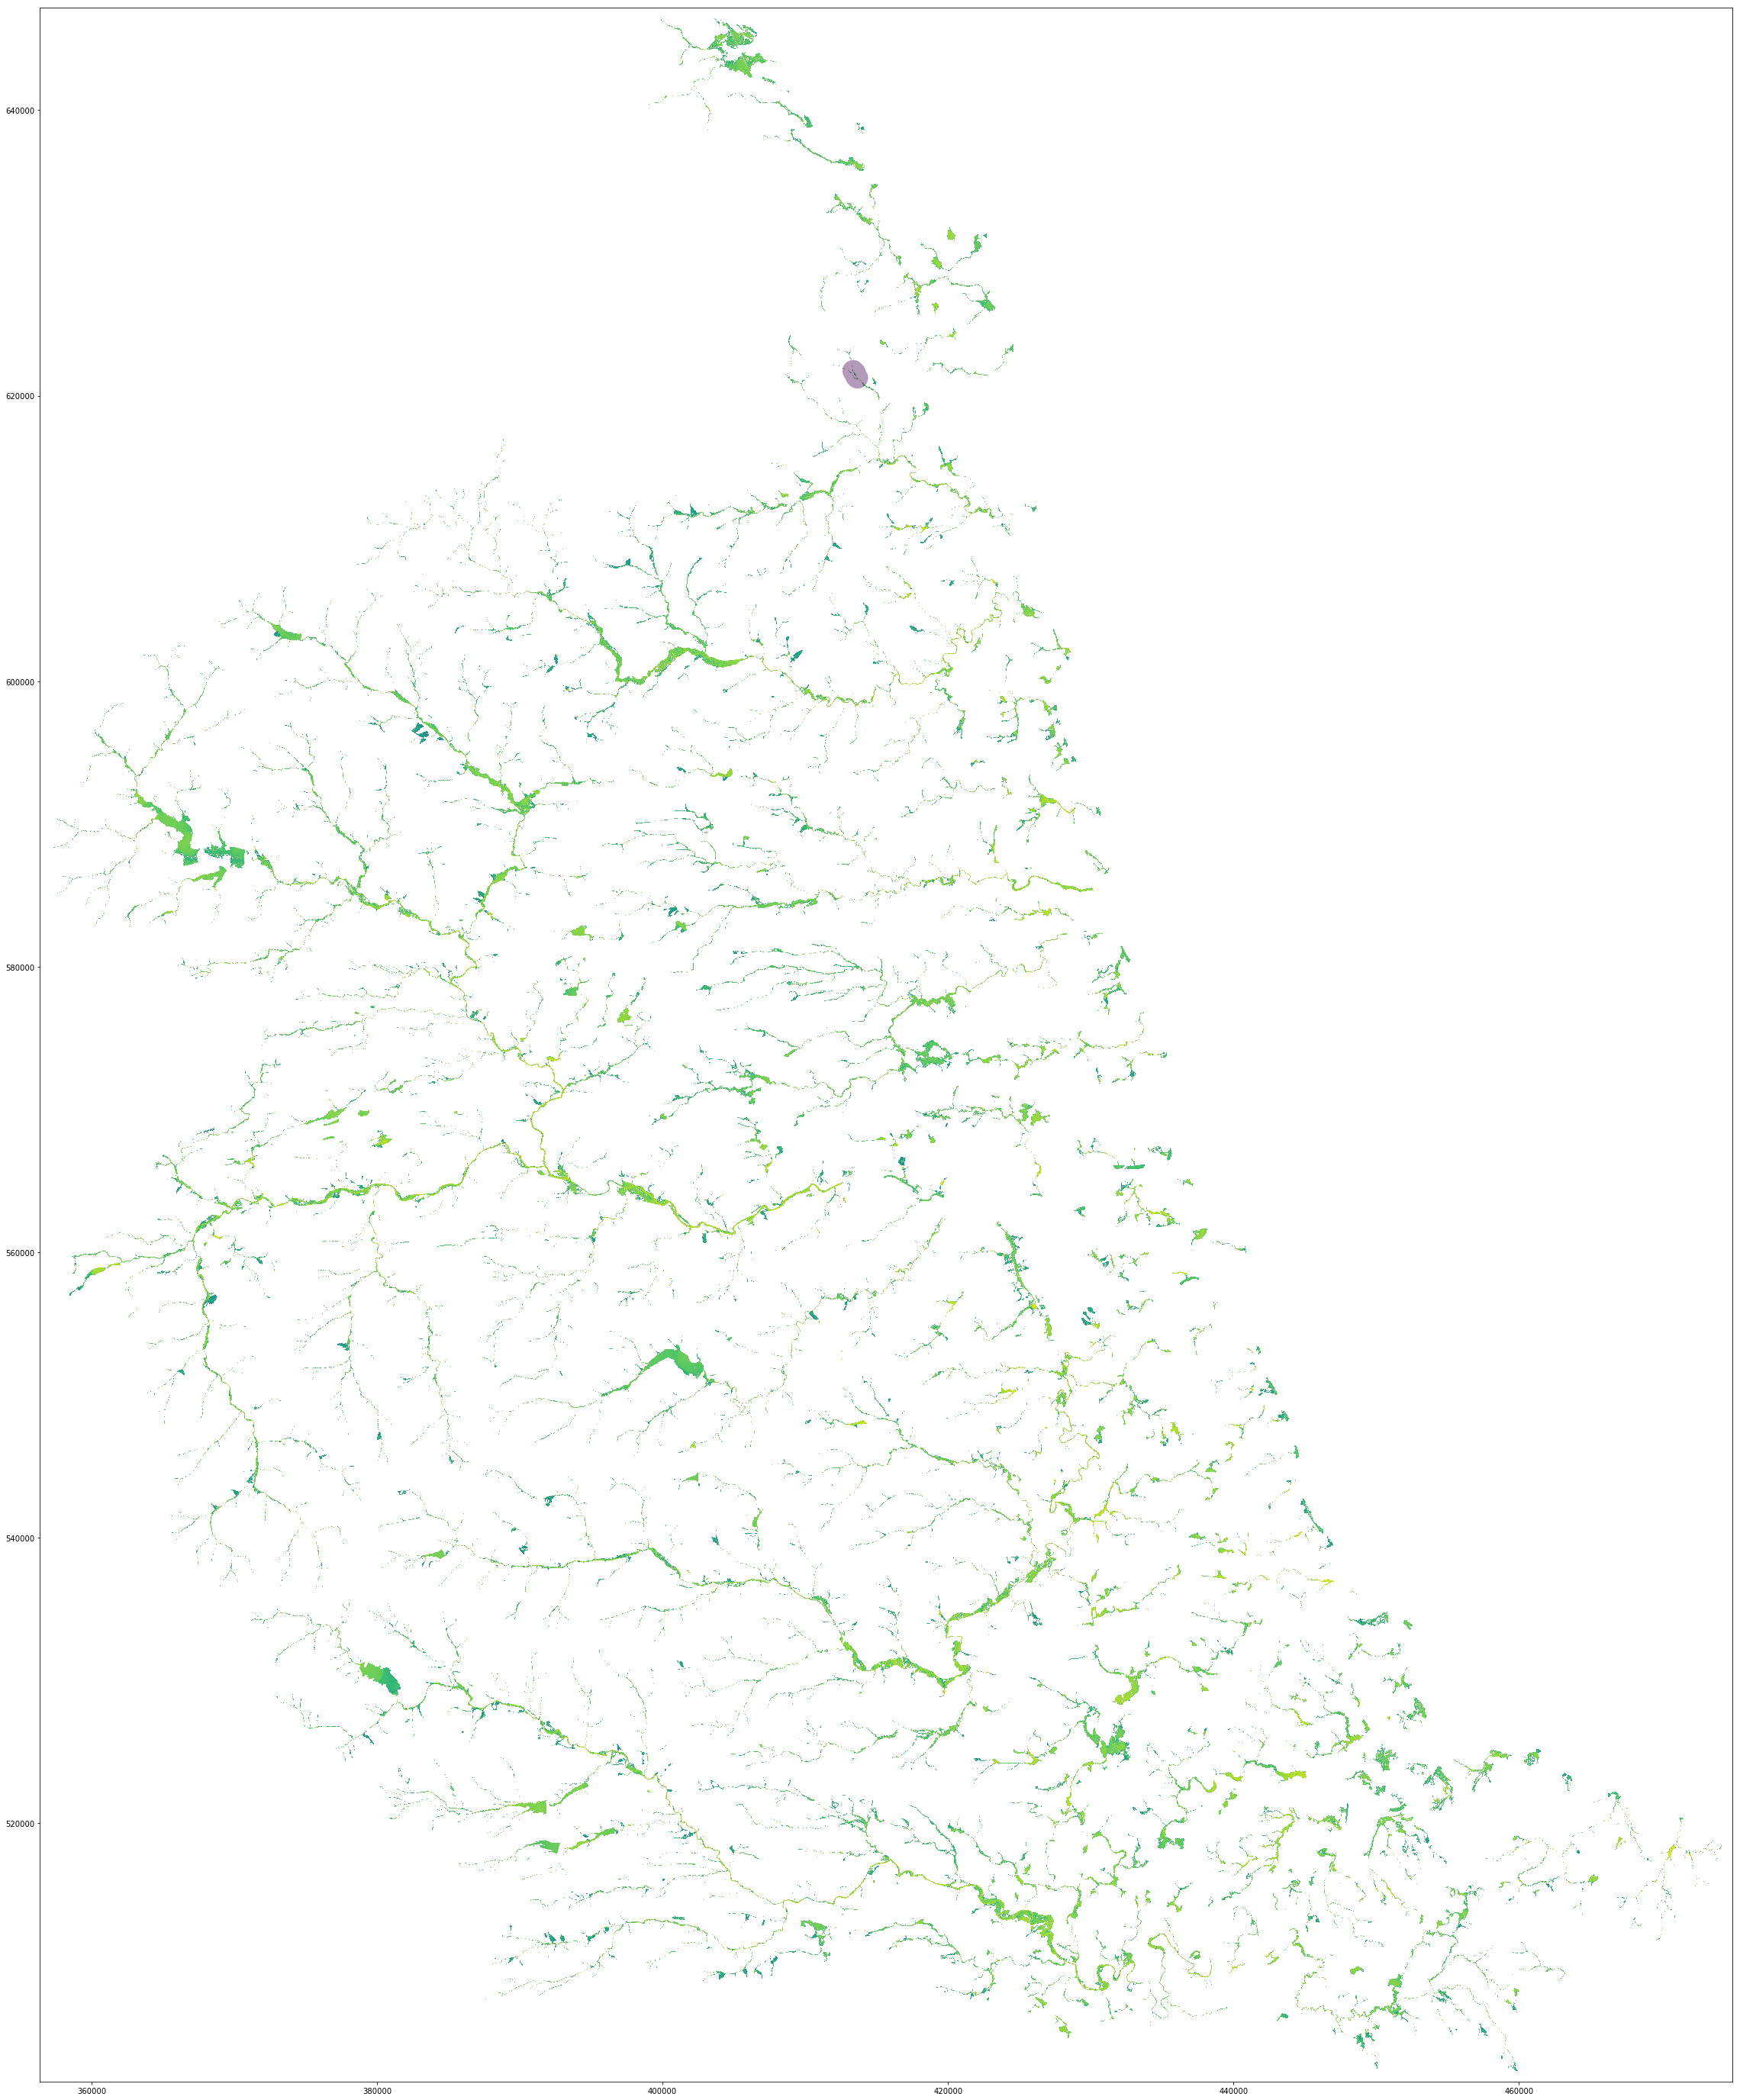

In [29]:
fig, ax = plt.subplots(figsize=(50,50))
plt.imshow(np.log10(arr), vmin=np.log10(band.GetMinimum()), vmax=np.log10(band.GetMaximum()), cmap='viridis', extent=extent_lonlat)
p = PatchCollection(patches, alpha=0.4)
p.set_array(np.array(colors))
ax.add_collection(p)


## Ideas
1. create bluured outline from raster image, create blurred outline from shapefile, look at residual. Where residual is low there is correlation
2. cross correlate shape file with image. Correlation likely when curveture of floodmap is same as curvature of shapefile
3. Scan around shapefile. Plot pixel difference across boundary